## Quantum support vector regression for disability insurance

B. Djehiche and B. Löfdahl – KTH, Department of Mathematics / SEB – 
Risks 2021, 9(12), 216; https://doi.org/10.3390/risks9120216

Hands-on assistance: https://enccs.se/anastasiia-andriievska

In [1]:
from qiskit_iqm import IQMProvider
import networkx as nx
from qiskit import QuantumCircuit, QuantumRegister, execute, transpile
from qiskit.visualization import *
import pylatexenc
import pandas as pd
import numpy as np
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.utils import QuantumInstance
from qiskit.tools.monitor import job_monitor
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
import qiskit.quantum_info as qi

import matplotlib.pyplot as plt
from sklearn.svm import SVR

In [2]:
provider = IQMProvider("https://qc.vtt.fi/cocos")
backend = provider.get_backend()

In [3]:
print(f'Native operations: {backend.operation_names}')
print(f'Number of qubits: {backend.num_qubits}')
print(f'Coupling map: {backend.coupling_map}')

Native operations: ['r', 'id', 'cz', 'measure']
Number of qubits: 5
Coupling map: [[0, 2], [2, 0], [1, 2], [2, 1], [2, 3], [3, 2], [2, 4], [4, 2]]


In [4]:
import qiskit
qiskit.__version__

'0.25.2'

First, we create some dummy data. The x-variable holds the available data. x[1] represents gender (0 or 1). x[2] represents age, normalized to the [0,1] interval. The y-variable is the value that we seek to model. It represents the logistic transition probability between two states. The w-variable represents the weight that we assign to each data point.

In [5]:
nsamp = 100
x = np.array( [[0.0, x/nsamp] for x in range(nsamp)] + [[1.0, x/nsamp] for x in range(nsamp)] )
y = np.array([-4.5 + 0.2*a[0] + a[1]*(1+a[0]*0.2) + 0.1*np.random.normal() for a in x])

p = 1/(1+np.exp(-y))

n = [int(200 + 600*xj[1]/0.7) if xj[1] <= 0.7 else int(800 - 300*(xj[1]-0.7)/0.3) for xj in x]

d = [nj*pj for nj,pj in zip(n,p)]

We can use the Pandas library to create a DataFrame and then save it as a CSV file, which support column headers. This will create a CSV file with each column labeled as ‘gender’, ‘age group (normalized)’, ‘population size’, and ‘number of transitions’ respectively. The index=False argument is used to prevent pandas from writing row indices into the file.

In [ ]:
# Create a DataFrame
df = pd.DataFrame({
    'gender': [a[0] for a in x],
    'age group (normalized)': [a[1] for a in x],
    'population size': n,
    'number of transitions': d
})

# Write the DataFrame to a CSV file
df.to_csv('fdata.csv', index=False)  # index=False argument is used to prevent pandas from writing row indices into the CSV file

One can read the data back from the file like this:

In [6]:
data = pd.read_csv('fdata.csv')

### Transform and inspect data

In [7]:
x = np.array( [[a,b] for a,b in zip(data['gender'], data['age group (normalized)'])] )
print(x)

[[0.   0.  ]
 [0.   0.01]
 [0.   0.02]
 [0.   0.03]
 [0.   0.04]
 [0.   0.05]
 [0.   0.06]
 [0.   0.07]
 [0.   0.08]
 [0.   0.09]
 [0.   0.1 ]
 [0.   0.11]
 [0.   0.12]
 [0.   0.13]
 [0.   0.14]
 [0.   0.15]
 [0.   0.16]
 [0.   0.17]
 [0.   0.18]
 [0.   0.19]
 [0.   0.2 ]
 [0.   0.21]
 [0.   0.22]
 [0.   0.23]
 [0.   0.24]
 [0.   0.25]
 [0.   0.26]
 [0.   0.27]
 [0.   0.28]
 [0.   0.29]
 [0.   0.3 ]
 [0.   0.31]
 [0.   0.32]
 [0.   0.33]
 [0.   0.34]
 [0.   0.35]
 [0.   0.36]
 [0.   0.37]
 [0.   0.38]
 [0.   0.39]
 [0.   0.4 ]
 [0.   0.41]
 [0.   0.42]
 [0.   0.43]
 [0.   0.44]
 [0.   0.45]
 [0.   0.46]
 [0.   0.47]
 [0.   0.48]
 [0.   0.49]
 [0.   0.5 ]
 [0.   0.51]
 [0.   0.52]
 [0.   0.53]
 [0.   0.54]
 [0.   0.55]
 [0.   0.56]
 [0.   0.57]
 [0.   0.58]
 [0.   0.59]
 [0.   0.6 ]
 [0.   0.61]
 [0.   0.62]
 [0.   0.63]
 [0.   0.64]
 [0.   0.65]
 [0.   0.66]
 [0.   0.67]
 [0.   0.68]
 [0.   0.69]
 [0.   0.7 ]
 [0.   0.71]
 [0.   0.72]
 [0.   0.73]
 [0.   0.74]
 [0.   0.75]
 [0.   0.76]

In [8]:
# raw transition frequency per group, used for plots
p_raw = [a/b for a,b in zip(d,n)]

# logistic probability, used as input to SVR optimization
y = np.array([np.log( p / (1-p) ) for p in p_raw])

# calculate weights for SVR based on population size
w = np.array([1./nj for nj in n])

# normalize weights (equivalent to changing the hyperparameters of the SVR)
w = w/sum(w)*len(x)

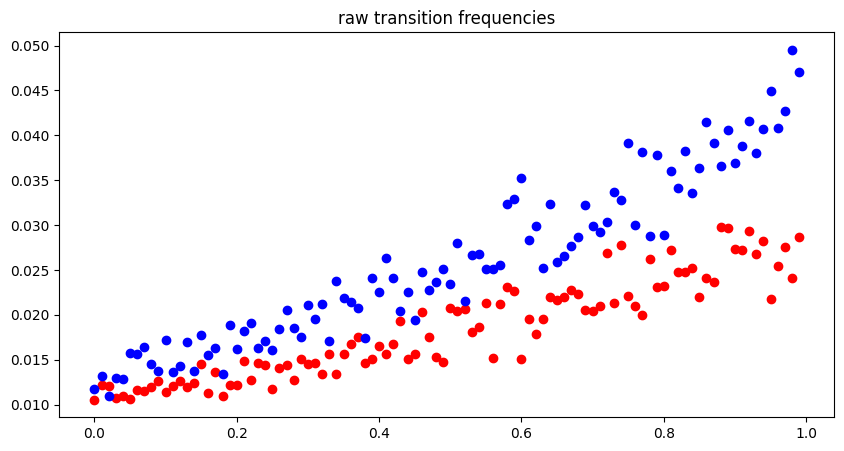

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot([xj[1] for xj,p in zip(x, p_raw) if xj[0] == 0], [p for xj,p in zip(x, p_raw) if xj[0] == 0], 'or')
axs.plot([xj[1] for xj,p in zip(x, p_raw) if xj[0] == 1], [p for xj,p in zip(x, p_raw) if xj[0] == 1], 'ob')
axs.set_title("raw transition frequencies")
plt.show()

The first step of the modelling is to define the mapping from data space to our quantum feature space. This is done by setting up the qc circuit. The circuit below is a very simplified two-variable circuit. Feel free to experiment!

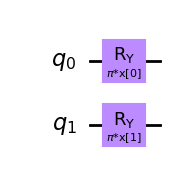

In [10]:
# set up 'kernel circuit'
p = ParameterVector('x', length=2)
qc = QuantumCircuit(2)

qc.ry(p[0]*np.pi, 0)
qc.ry(p[1]*np.pi, 1)

qc.draw('mpl')

## Exercise

Experimenting with quantum circuits involves changing the structure of the circuit or the parameters used. Here are a few ways you can experiment with the given circuit:

1. **Change the gates**: Instead of using `ry` gates, you could use other gates like `rx`, `rz`, `h` (Hadamard), etc.

```python
qc.rx(p[0]*np.pi, 0)
qc.rz(p[1]*np.pi, 1)
```

2. **Add more gates**: You can add more gates to your circuit to make it more complex.

```python
qc.ry(p[0]*np.pi, 0)
qc.ry(p[1]*np.pi, 1)
qc.h(0)
qc.cx(0, 1) # CNOT gate
```

3. **Change the parameters**: Instead of multiplying the parameters by `pi`, you could multiply them by other constants or use more complex functions of the parameters.

```python
qc.ry(p[0], 0)
qc.ry(np.sin(p[1]), 1)
```

4. **Increase the number of qubits**: You can increase the number of qubits in your circuit and see how that affects your results.

Remember, when experimenting with quantum circuits, it's important to understand what each gate does and how changing the circuit might affect your results. Happy experimenting! 😊

A few general guidelines for experimenting with quantum circuits:

1. **Understand the problem**: Before you start experimenting, make sure you understand the problem you're trying to solve and how a quantum circuit could help solve it.

2. **Start simple**: Start with a simple circuit and gradually add complexity. This makes it easier to understand what each part of your circuit is doing.

3. **Use a variety of gates**: Different gates can have different effects on your quantum state, so try using a variety of gates in your experiments.

4. **Test on a simulator first**: Before running your circuit on a real quantum computer, test it on a simulator to make sure it's working as expected.

5. **Analyze your results**: After running your circuit, analyze the results to see if they make sense and if they're helping you solve your problem.

6. **Iterate**: Experimenting with quantum circuits often involves a lot of trial and error. Don't be afraid to iterate on your design and try new things.

In the context of the Quantum Support Vector Regression (QSVR) for disability insurance that you're working on, you might want to experiment with different ways of encoding your data into the quantum state or different types of quantum kernels. Remember, the goal is to find a quantum circuit that can effectively model your data and help you make accurate predictions.

#### Tips
1. x[0] is a binary variable representing gender. Hence, flipping the first qubit from |0> to |1> based on gender will maximize the distance (wrt only the first qubit) between two subpopulations belong to different genders.

2. x[1] is a representing age. For two sub-populations of similar age, the rotations of the second qubit will be similar, causing a low distance (wrt only the second qubit).

3. One possible extension is to add a third qubit that would capture a first order interaction effect between x[0] and x[1], e.g. a cy or cx gate. We could also incorporate this by adding more gates to qubits 1 or 2.

In [ ]:
# Test code here
# Then rerun the following cells 



The QuantumKernel function prepares the kernel estimation by setting up inner product circuits, based on each combination of two data points.

In [11]:
zz_kernel = QuantumKernel(feature_map=qc, quantum_instance=Aer.get_backend('statevector_simulator'))

Then we specify the quantum instance: 

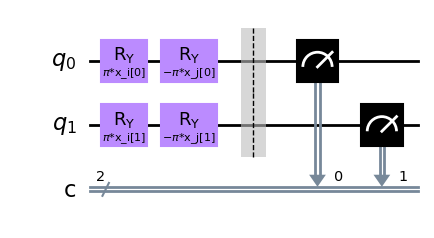

In [12]:
zz_circuit = zz_kernel.construct_circuit(ParameterVector('x_i', length=2),ParameterVector('x_j', length=2))
zz_circuit.decompose().draw(output='mpl')

We evaluate the kernel matrix based on our x data.

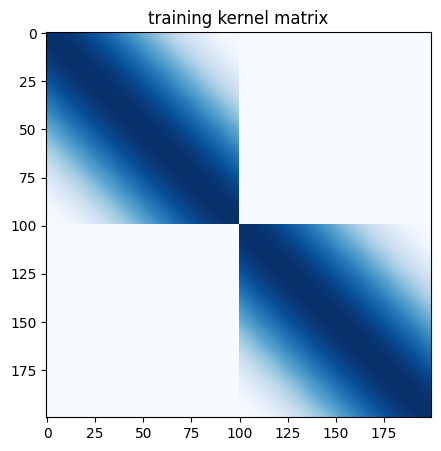

In [13]:
matrix_train = zz_kernel.evaluate(x_vec=x)

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs.set_title("training kernel matrix")
plt.show()

Figure 1 displays the estimated kernel matrix. This matrix has an interesting structure: it is block-diagonal. This is due to the fact that the second quadrant of the matrix correspond to the inner products of the  population groups with gender=0. These share the common characteristic gender=0, and each row is similar to its neighbours due to the encoding: similar ages are also similar in the quantum feature space. Analogously, the fourth quadrant of the matrix contains the gender=1 population groups. The first and third quadrants contain the inner products between gender=0 and gender=1 population groups and so are dissimilar in the quantum feature space.

Next, we run a support vector regression (SVR) taking the kernel matrix, the weights, and the y-values as input.

score: 0.9257961080373163


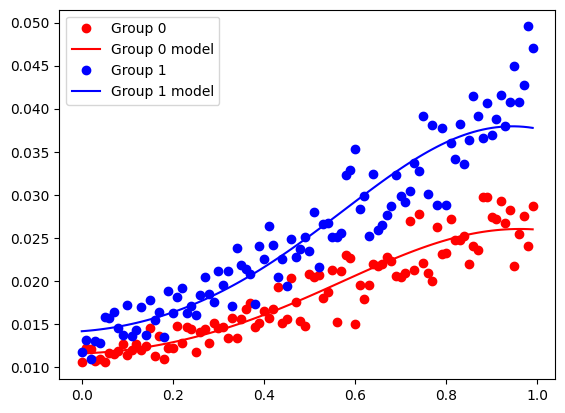

In [14]:
f_matrix_train = matrix_train

zzpc_svr = SVR(kernel='precomputed')
zzpc_svr.fit(f_matrix_train, y, w)
zzpc_score = zzpc_svr.score(f_matrix_train, y, w)
print(f'score: {zzpc_score}')
pred = zzpc_svr.predict(f_matrix_train)

p_hat = 1/(1+np.exp(-pred))
p = 1/(1+np.exp(-y))
plt.figure()
plt.plot([a[1] for a in x if a[0] == 0], [p for a,p in zip(x,p) if a[0] == 0],'or')
plt.plot([a[1] for a in x if a[0] == 0], [p for a,p in zip(x,p_hat) if a[0] == 0],'r')
plt.plot([a[1] for a in x if a[0] == 1], [p for a,p in zip(x,p) if a[0] == 1],'ob')
plt.plot([a[1] for a in x if a[0] == 1], [p for a,p in zip(x,p_hat) if a[0] == 1],'b')
plt.legend(['Group 0', 'Group 0 model', 'Group 1', 'Group 1 model'])
plt.show()

The score you see is the R-squared score from the SVR model. This score represents the proportion of the variance in the dependent variable that is predictable from the independent variables1. In other words, it gives you a measure of how well your model is fitting the data. A score of 1.0 indicates a perfect fit.

We check the results against a classical SVR.

score: 0.9365135835012351


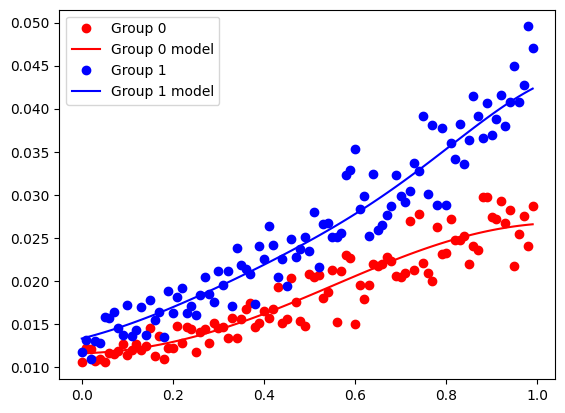

In [15]:
classical = SVR(kernel='rbf')
classical.fit(x, y, w)
classical_score = classical.score(x, y, w)
print(f'score: {classical_score}')
pred = classical.predict(x)

p_hat = 1/(1+np.exp(-pred))
p = 1/(1+np.exp(-y))
plt.figure()
plt.plot([a[1] for a in x if a[0] == 0], [p for a,p in zip(x,p) if a[0] == 0],'or')
plt.plot([a[1] for a in x if a[0] == 0], [p for a,p in zip(x,p_hat) if a[0] == 0],'r')
plt.plot([a[1] for a in x if a[0] == 1], [p for a,p in zip(x,p) if a[0] == 1],'ob')
plt.plot([a[1] for a in x if a[0] == 1], [p for a,p in zip(x,p_hat) if a[0] == 1],'b')
plt.legend(['Group 0', 'Group 0 model', 'Group 1', 'Group 1 model'])
plt.show()

The above analysis is done in-sample. Below, we use the leave-one-out cross-validation functionality from the sklearn module.

In [16]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score

zzpc_svr = SVR(kernel='precomputed')
classical = SVR(kernel='rbf')

cols = range(len(x))

loo = LeaveOneOut()
pred_loo = []
pred_loo_classic = []
used_K = matrix_train
for train_index, test_index in loo.split(cols):
    #print(x[train_index])
    zzpc_svr.fit(used_K[np.ix_(train_index,train_index)], y[train_index], w[train_index])
    pred = zzpc_svr.predict(used_K[np.ix_(test_index,train_index)])
    for p in pred:
        pred_loo.append(p)
    classical.fit(x[train_index], y[train_index], w[train_index])
    cpred = classical.predict(x[test_index])
    for p in cpred:
        pred_loo_classic.append(p)
pred_loo = np.array(pred_loo)
pred_loo_classic = np.array(pred_loo_classic)

In [17]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score

def predict_loo(K, y, w, zzpc_svr):
    cols = range(len(y))
    loo = LeaveOneOut()
    pred_loo = []
    for train_index, test_index in loo.split(cols):
        #print(x[train_index])
        zzpc_svr.fit(K[np.ix_(train_index,train_index)], y[train_index], w[train_index])
        pred = zzpc_svr.predict(K[np.ix_(test_index,train_index)])
        for p in pred:
            pred_loo.append(p)
    return np.array(pred_loo)

statevector_loo = predict_loo(matrix_train, y, w, SVR(kernel='precomputed'))

score: 0.9156732599722917


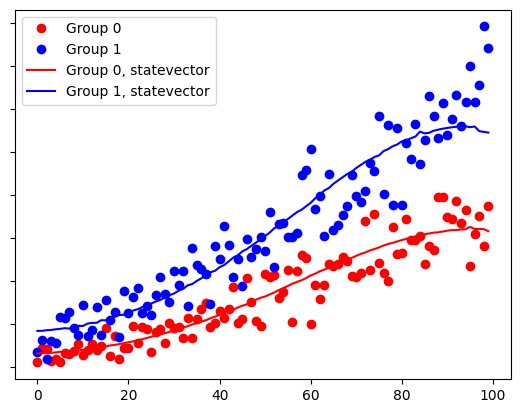

In [18]:
p_hat = 1/(1+np.exp(-statevector_loo))
p = 1/(1+np.exp(-y))
score = r2_score(p, p_hat, sample_weight=w)
print(f'score: {score}')
fig, ax = plt.subplots(1, 1)
plt.plot(np.array([a[1] for a in x if a[0] == 0])*100, [p for a,p in zip(x,p) if a[0] == 0],'or')
plt.plot(np.array([a[1] for a in x if a[0] == 1])*100, [p for a,p in zip(x,p) if a[0] == 1],'ob')
plt.plot(np.array([a[1] for a in x if a[0] == 0])*100, [p for a,p in zip(x,p_hat) if a[0] == 0],'r')
plt.plot(np.array([a[1] for a in x if a[0] == 1])*100, [p for a,p in zip(x,p_hat) if a[0] == 1],'b')
plt.legend(['Group 0', 'Group 1', 'Group 0, statevector', 'Group 1, statevector'])
ax.axes.yaxis.set_ticklabels([])
plt.show()

Quantum Support Vector Regression (QSVR) Score (0.9155345528008413): This score suggests that your QSVR model is doing a good job of capturing the relationship between your features and your target variable.

Classical Support Vector Regression (SVR) Score (0.9295558682302361): This score is slightly higher than your QSVR score, suggesting that your classical SVR model might be fitting the data slightly better than your QSVR model.

Leave-One-Out Cross-Validation Score (0.8977158412990511): This score is lower than both your QSVR and classical SVR scores. This isn’t surprising, as leave-one-out cross-validation can often result in lower scores because it’s a more rigorous form of validation. It’s a good way to get an unbiased estimate of how well your model will perform on unseen data.

To compare these results, you can look at how much each score deviates from 1.0. The closer the score is to 1.0, the better the model is fitting your data. However, keep in mind that a high R-squared score doesn’t always mean your model will perform well on unseen data. It’s important to also look at other metrics and plots (like residuals) to assess your model’s performance.

## Exercise
In the context of regression analysis, residuals are the difference between the observed (actual) and predicted values for a data point. In other words, a residual is an error in prediction.

Mathematically, if you have an observed value $$y_{\text{obs}}$$ and a predicted value $$y_{\text{pred}}$$ for a data point, the residual $$e$$ for that data point is calculated as:

$$e = y_{\text{obs}} - y_{\text{pred}}$$

Residuals are used to understand the accuracy of a regression model. If a model fits the data well, the residuals should be small and randomly distributed around zero. Patterns or trends in the residuals can indicate that the model is not adequately capturing some aspect of the data.

In our case, we will plot a histogram of residuals from our QSVR model. This visualization can help us understand the distribution of errors made by the model.
If the model is performing well, we would expect to see most residuals close to zero, indicating that the predicted and actual values are close. Large residuals indicate that the model's predictions are far off from the actual values.

#### Tips
1. use `residuals = y - pred`
2. in `plt.hist`use `bins=20` # bins parameter determines the number of bins (or bars) to divide your data into
3. use appropriate lables
4. *Advanced* – use `p_hat-p` for residuals

In [ ]:
# solution
residuals = y - pred
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [ ]:
# solution
residuals1 = p_hat-p
plt.hist(residuals1, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

You've done a great job implementing the Quantum Support Vector Regression (QSVR) and comparing it with a classical SVR. You've also used leave-one-out cross-validation to evaluate the performance of your models, which is a robust method for estimating the generalization error.

In terms of the residuals, you've plotted two histograms:
1. The first histogram represents the residuals calculated as `y - pred`, where `y` is the observed value and `pred` is the predicted value from your QSVR model. This gives you an idea of how well your model is predicting the actual `y` values. If your model is accurate, most residuals should be close to zero, indicating that the predicted and actual values are close. Large residuals indicate that the model's predictions are far off from the actual values.
2. The second histogram represents the residuals calculated as `p_hat - p`, where `p_hat` is the predicted probability and `p` is the actual probability. This gives you an idea of how well your model is predicting the actual probabilities. Again, if your model is accurate, most residuals should be close to zero.

To describe the results, you would typically look at the distribution of residuals in your histograms. If your model is performing well, you would expect to see a distribution centered around zero, indicating that most predictions are close to the actual values or probabilities. If you see a skewed distribution or a distribution with a long tail, it might indicate that your model is systematically overestimating or underestimating the values or probabilities.

In terms of what you've done here, you've implemented a QSVR for modeling transition probabilities in disability insurance, compared it with a classical SVR, and evaluated their performance using leave-one-out cross-validation and residual analysis. This is a comprehensive approach to developing and evaluating predictive models. Great work! 😊

We used the simulator and now we'll run it on Helmi.

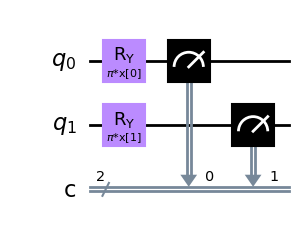

In [19]:
# Set up 'kernel circuit'
p = ParameterVector('x', length=2)
qc = QuantumCircuit(2, 2)  # Added a classical register with 2 bits

# Apply RY gates to each qubit
qc.ry(p[0]*np.pi, 0)
qc.ry(p[1]*np.pi, 1)

# Add measurements
qc.measure(0, 0)
qc.measure(1, 1)

# Draw the circuit
qc.draw('mpl')

#### TEST CODE